In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV , cross_val_score, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import metrics

In [57]:
!pip install shap
!pip install optuna
!pip install category_encoders
!pip install catboost

In [58]:
# checking the correlation to the target variable with the chi square.
# if the p-value is under 0.05, the correlation to the target variable is statistically significant.
def check_correlation(df,col,target_col):
  contigency = pd.crosstab(df[col],df[target_col])
  res = chi2_contingency(contigency)
  print(f"{col} - {target_col} : ", 'Correlated 'if res[1] < 0.05  else 'Not Correlated', ',',res[1])

# count probability acceptance to the column.
def probability(df, col):
  yes_man = df.loc[(df['Y'] == 1), col].value_counts()
  value_counts = df[col].value_counts()

  val_index = value_counts.index

  ratio_yes = yes_man / value_counts

  return  val_index, ratio_yes*100

# show the distribution of the column and its probability
def show_dist_prob(df, col):
    idx_occ, prob_occ = probability(df, col)

    occ_val_counts = df[col].value_counts()

    fig = make_subplots(cols=2, rows=1, subplot_titles=['Value Counts', 'Acceptance Probability'], shared_yaxes=True)

    fig.add_trace(
        go.Bar(x=occ_val_counts, y=occ_val_counts.index, orientation='h'),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(x=prob_occ, y=idx_occ, orientation='h'),
        row=1, col=2
    )

    fig.update_layout(title=col, width=800, height=600)


In [59]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency,pointbiserialr
from scipy.stats.contingency import association
import plotly.express as px

In [60]:
df = pd.read_csv('train.csv')
df.head()

,customer_id,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,258868,No Urgent Place,Friend(s),Sunny,80,6PM,Restaurant(<20),1d,Male,21,...,1~3,4~8,4~8,never,1,1,0,0,1,1
1,318369,Work,Alone,Sunny,80,7AM,Restaurant(<20),2h,Male,21,...,1~3,4~8,1~3,less1,1,0,0,1,0,0
2,320906,No Urgent Place,Alone,Sunny,80,10AM,Coffee House,2h,Female,21,...,gt8,4~8,1~3,1~3,1,1,0,0,1,0
3,412393,Work,Alone,Rainy,55,7AM,Restaurant(<20),2h,Female,26,...,less1,4~8,1~3,never,1,1,1,0,1,0
4,290854,Home,Alone,Snowy,30,6PM,Coffee House,1d,Male,31,...,less1,4~8,less1,never,1,1,0,0,1,0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10147 entries, 0 to 10146
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   customer_id           10147 non-null  int64 
 1   destination           10147 non-null  object
 2   passanger             10147 non-null  object
 3   weather               10147 non-null  object
 4   temperature           10147 non-null  int64 
 5   time                  10147 non-null  object
 6   coupon                10147 non-null  object
 7   expiration            10147 non-null  object
 8   gender                10147 non-null  object
 9   age                   10147 non-null  object
 10  maritalStatus         10147 non-null  object
 11  has_children          10147 non-null  int64 
 12  education             10147 non-null  object
 13  occupation            10147 non-null  object
 14  income                10147 non-null  object
 15  car                   84 non-null   

In [62]:
df.describe()

,customer_id,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,10147.000000,10147.000000,10147.000000,10147.0,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000
mean,311272.276831,63.172366,0.412634,1.0,0.563024,0.119838,0.212181,0.787819,0.568444
std,106781.701016,19.232595,0.492332,0.0,0.496037,0.324788,0.408872,0.408872,0.495318
min,123472.000000,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,221439.000000,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,310062.000000,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,401537.000000,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,499988.000000,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
df.isna().sum()

customer_id                 0
destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     10063
Bar                        88
CoffeeHouse               172
CarryAway                 122
RestaurantLessThan20       97
Restaurant20To50          148
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

In [64]:
y = df['Y'].value_counts()

px.bar(x = y.index , y = y, title = 'Y Value', width = 600, height = 400, color = y.index)


In [65]:
test = pd.read_csv('test.csv')
test.head()

,customer_id,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp
0,374679,No Urgent Place,Friend(s),Sunny,80,6PM,Coffee House,1d,Female,below21,...,never,1~3,less1,4~8,less1,1,0,0,0,1
1,469678,Home,Alone,Sunny,80,6PM,Carry out & Take away,2h,Male,21,...,1~3,never,gt8,4~8,1~3,1,1,0,1,0
2,216140,No Urgent Place,Alone,Rainy,55,10AM,Coffee House,1d,Female,26,...,never,never,1~3,less1,never,1,1,0,0,1
3,184301,No Urgent Place,Partner,Sunny,80,6PM,Bar,1d,Male,50plus,...,never,4~8,4~8,1~3,less1,1,1,0,0,1
4,148720,Work,Alone,Sunny,30,7AM,Carry out & Take away,1d,Female,26,...,never,never,1~3,4~8,less1,1,1,0,0,1


In [66]:
test.tail()

,customer_id,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp
2532,356045,No Urgent Place,Kid(s),Sunny,80,2PM,Coffee House,1d,Female,26,...,never,never,less1,less1,less1,1,0,0,0,1
2533,498759,No Urgent Place,Kid(s),Sunny,80,10AM,Carry out & Take away,2h,Male,36,...,less1,1~3,4~8,1~3,1~3,1,1,0,0,1
2534,356159,Work,Alone,Sunny,55,7AM,Coffee House,2h,Female,31,...,less1,less1,gt8,4~8,less1,1,1,1,0,1
2535,218541,Home,Kid(s),Snowy,30,10PM,Restaurant(20-50),2h,Female,31,...,never,1~3,1~3,1~3,1~3,1,1,0,0,1
2536,467387,No Urgent Place,Friend(s),Sunny,55,10PM,Bar,2h,Female,21,...,1~3,gt8,4~8,4~8,less1,1,1,0,0,1


In [67]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2537 entries, 0 to 2536
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   customer_id           2537 non-null   int64 
 1   destination           2537 non-null   object
 2   passanger             2537 non-null   object
 3   weather               2537 non-null   object
 4   temperature           2537 non-null   int64 
 5   time                  2537 non-null   object
 6   coupon                2537 non-null   object
 7   expiration            2537 non-null   object
 8   gender                2537 non-null   object
 9   age                   2537 non-null   object
 10  maritalStatus         2537 non-null   object
 11  has_children          2537 non-null   int64 
 12  education             2537 non-null   object
 13  occupation            2537 non-null   object
 14  income                2537 non-null   object
 15  car                   24 non-null     

In [68]:
numeric_cols = df.select_dtypes(include = 'number').columns.to_list()
fig = make_subplots(rows= 2 , cols=4, subplot_titles = numeric_cols)

In [69]:
numeric_cols_2 = test.select_dtypes(include = 'number').columns.to_list()
fig = make_subplots(rows= 2 , cols=4, subplot_titles = numeric_cols)

In [70]:
#Weather
val_counts_weather = df['weather'].value_counts()

val_counts_weather_with_y = df.groupby(['weather','Y']).size().reset_index(name="counts")


px.pie(names = val_counts_weather.index, values = val_counts_weather, title = 'Weather Frequency', width = 800, height = 600)

In [71]:
index, ratio_weather = probability(df,'weather')

fig = px.bar(x = index , y = ratio_weather , title = 'Probability of True Value Based on Coupon Acceptance and Weather', width = 800, height = 600)
fig.show()
check_correlation(df.copy(),'weather','Y')

weather - Y :  Correlated  , 5.589853450561661e-22


In [72]:
#Same Vs Opposite Direction
fig = make_subplots(rows= 1 , cols= 2, subplot_titles = ['same direction', 'opposite'])

same_idx, same_val = probability(df.copy(),'direction_same')
opp_idx, opp_val = probability(df.copy(),'direction_opp')

print(pd.crosstab(df['direction_same'], df['Y']))

fig.add_trace(
    go.Bar(x = opp_idx, y = opp_val), row = 1 , col = 1
)

fig.add_trace(
    go.Bar(x = same_idx, y = same_val), row = 1, col = 2
)
fig.update_layout(height=400, width=600, title_text="Same vs opposite probability to the coupon acceptance")
fig.show()
check_correlation(df,'direction_same','Y')
check_correlation(df,'direction_opp','Y')

Y                  0     1
direction_same            
0               3479  4515
1                900  1253


direction_same - Y :  Not Correlated , 0.16030602505249975
direction_opp - Y :  Not Correlated , 0.16030602505249975


In [73]:
#Time and Expire Day
time_idx, time_prob = probability(df.copy(),'time')
expire_idx, expire_prob = probability(df.copy(),'expiration')

fig = make_subplots(rows= 1 , cols= 2, subplot_titles = ['Time', 'Expiration'])

fig.add_trace(
    go.Bar(x = time_idx, y = time_prob), row = 1 , col = 1
)

fig.add_trace(
    go.Bar(x = expire_idx, y = expire_prob), row = 1, col = 2
)

fig.update_layout(height=400, width=600, title_text="Probability to The Coupon Acceptance")
fig.show()

In [74]:
check_correlation(df.copy(),'time','Y')
check_correlation(df.copy(),'expiration','Y')

time - Y :  Correlated  , 1.128890957557028e-28
expiration - Y :  Correlated  , 7.484620305309943e-41


In [117]:
for i in df.columns:
    print(i, df[i].unique())

customer_id [258868 318369 320906 ... 173367 488688 431162]
destination ['No Urgent Place' 'Work' 'Home']
passanger ['Friend(s)' 'Alone' 'Partner' 'Kid(s)']
weather ['Sunny' 'Rainy' 'Snowy']
temperature [80 55 30]
time ['6PM' '7AM' '10AM' '10PM' '2PM']
coupon ['Restaurant(<20)' 'Coffee House' 'Restaurant(20-50)' 'Bar'
 'Carry out & Take away']
expiration ['1d' '2h']
gender ['Male' 'Female']
age ['21' '26' '31' '50plus' '36' '41' '46' 'below21']
maritalStatus ['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']
has_children [0 1]
education ['Some college - no degree' 'Bachelors degree'
 'Graduate degree (Masters or Doctorate)' 'Associates degree'
 'High School Graduate' 'Some High School']
occupation ['Student' 'Computer & Mathematical' 'Unemployed' 'Healthcare Support'
 'Retired' 'Food Preparation & Serving Related' 'Sales & Related'
 'Architecture & Engineering' 'Education&Training&Library'
 'Arts Design Entertainment Sports & Media' 'Management'
 'Community & Social 

In [174]:
destination_map = {'nan': 0,
    'No Urgent Place': 0,
    'Work': 1,
    'Home': 2,
}
passanger_map = {'nan': 0,
                 'Friend(s)':0,
                 'Alone': 1,
                 'Partner':2,
                 'Kid(s)': 3
}
expiration_map = {'nan': 0,
    '1d': 0,
                  '2h': 1
}
frequency_map = {
    'nan': 0,
    'never': 0,
    'less1': 1,
    '1~3': 2,
    '4~8': 3,
    'gt8': 4
}
age_map = {
    'nan': 0,
    'below21': 0,
    '21': 1,
    '26': 2,
    '31': 3,
    '36': 4,
    '41': 5,
    '46': 6,
    '50plus': 7
}
income_map = {
    'nan': 0,
    'Less than $12500': 0,
    '$12500 - $24999': 1,
    '$25000 - $37499': 2,
    '$37500 - $49999': 3,
    '$50000 - $62499': 4,
    '$62500 - $74999': 5,
    '$75000 - $87499': 6,
    '$87500 - $99999': 7,
    '$100000 or More': 8
}
weather_map = { 'nan': 0,
    "Rainy":0,
            "Snowy":1,
            "Sunny":2
}
gender_map = {'nan': 0,
    'Male': 0,
              'Female':1
}
temp_map = {'nan': 0,
    30:0,
           55:1,
           80:2
}
time_map = {'nan': 0,
    "7AM":0,
              "10AM":0,
              "2PM":1,
              "6PM":2,
              "10PM":2
}
education_map = {'nan': 0,
    "Some college - no degree":0,
          "Some High School":1,
          "High School Graduate":2,
          "Associates degree":3,
          "Bachelors degree":4,
          "Graduate degree (Masters or Doctorate)":5
}

cols = ["Bar", "CoffeeHouse" ,"CarryAway", "RestaurantLessThan20", "Restaurant20To50"]
labencod = {"nan":0,
            "never":0,
            "less1":1,
            "1~3":2,
            "4~8":3,
            "gt8":4
          }


In [175]:
frequency_cols = ['Restaurant20To50', 'RestaurantLessThan20',
                  'CarryAway', 'CoffeeHouse', 'Bar']

In [176]:
df1 = df.copy(deep=False)
for col in frequency_cols:
    df1[col] = df1[col].map(frequency_map)
df1.age = df1.age.map(age_map)
df1.passanger = df1.passanger.map(passanger_map)
df1.destination = df1.destination.map(destination_map)
df1.income = df1.income.map(income_map)
df1.weather = df1.weather.map(weather_map)
df1.temperature = df1.temperature.map(temp_map)
df1.time = df1.time.map(time_map)
df1.education = df1.education.map(education_map)
df1.expiration = df1.expiration.map(expiration_map)
df1.gender = df1.gender.map(gender_map)

In [177]:
for col in cols:
    df1[col] = df1[col].map(labencod)

In [178]:
test1 = test.copy(deep=False)
for col in frequency_cols:
    test1[col] = test1[col].map(frequency_map)
test1.age = test1.age.map(age_map)
test1.passanger = test1.passanger.map(passanger_map)
test1.destination = test1.destination.map(destination_map)
test1.income = test1.income.map(income_map)
test1.weather = test1.weather.map(weather_map)
test1.temperature = test1.temperature.map(temp_map)
test1.time = test1.time.map(time_map)
test1.education = test1.education.map(education_map)
test1.expiration = test1.expiration.map(expiration_map)
test1.gender = test1.gender.map(gender_map)

In [179]:
for col in cols:
    test1[col] = test1[col].map(labencod)

In [180]:
selected_col = ['age','gender','maritalStatus','has_children','toCoupon_GEQ5min','toCoupon_GEQ15min','toCoupon_GEQ25min','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50','destination','passanger']
fig = make_subplots(rows = 4, cols = 4, subplot_titles= selected_col)

for idx, col in enumerate(selected_col):
  val_counts = df[col].value_counts()
  fig.add_trace(
      go.Bar(x = val_counts.index, y = val_counts ), row = idx // 4 + 1 , col = idx % 4  + 1
  )

fig.update_layout(width = 1200, height = 1100, title = 'Others value distribution')
fig.show()

In [181]:
droped_column = ['car','toCoupon_GEQ5min','direction_same','direction_opp']
df1 = df1.drop(columns = droped_column)

In [182]:
df1.fillna(0, inplace=True)

In [183]:
test1 = test1.drop(columns = droped_column)

In [184]:
test1.fillna(0, inplace=True)

In [185]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier,AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier,Pool
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from imblearn.over_sampling import SMOTE
from category_encoders import CatBoostEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,recall_score,precision_score,f1_score,balanced_accuracy_score,roc_auc_score,ConfusionMatrixDisplay


models = {
    'logit':LogisticRegression,
    'decisionTree':DecisionTreeClassifier,
    'randomForest':RandomForestClassifier,
    'GradientBoost':GradientBoostingClassifier,
    'ExtraTrees':ExtraTreesClassifier,
    'LGBM':LGBMClassifier,
    'Xgboost':XGBClassifier,
    'adaboost':AdaBoostClassifier,
    'sgd':SGDClassifier,
    'catboost':CatBoostClassifier,
}

In [186]:
X = df1.drop(columns = 'Y')
y = df1.Y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [187]:
encoding_hot_target = ['destination','passanger','weather','maritalStatus','coupon', 'occupation']

In [188]:
def one_hot_encoding(df,col_li):
  one_hot = pd.get_dummies(df[col_li])
  df = pd.concat([df,one_hot],axis = 1)
  df = df.drop(columns = col_li)
  return df

X_train = one_hot_encoding(X_train,encoding_hot_target)
X_test = one_hot_encoding(X_test,encoding_hot_target)

In [189]:
test1 = one_hot_encoding(test1,encoding_hot_target)

In [192]:
def rename(df):
  map = {
    'passanger_Friend(s)':'passanger_Friends',
    'passanger_Kid(s)' : 'passanger_Kids',
    'coupon_Carry out & Take away' : 'coupon_CarryOut_TakeAway',
    'coupon_Restaurant(<20)':'coupon_Restaurant20'
  }
  return df.rename(columns = map)

X_train = rename(X_train)
X_test = rename(X_test)
test1 = rename(test1)

In [196]:
def find_model(models_li,X_train,y_train,X_test,y_test):
  data_frame = {'acc':[],'recall':[],'precision':[],'roc_auc':[]}

  for model_key,model in models_li.items() :
    m = None
    if model_key == 'logit':
       m = make_pipeline(StandardScaler(),model(random_state = 212))
    elif model_key == 'sgd':
      m = make_pipeline(StandardScaler(),model(loss = 'log_loss',random_state = 212))
    else :
      m = model(random_state = 212)

    m.fit(X_train,y_train)
    y_pred = m.predict(X_test)
    y_pred_proba = m.predict_proba(X_test)[:,1]
    data_frame['acc'].append(balanced_accuracy_score(y_test,y_pred))
    data_frame['recall'].append(recall_score(y_test,y_pred))
    data_frame['precision'].append(precision_score(y_test,y_pred))
    data_frame['roc_auc'].append(roc_auc_score(y_test,y_pred_proba))
  return pd.DataFrame(data_frame,index = list(models_li.keys()))

In [197]:
result = find_model(models,X_train,y_train,X_test,y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4594, number of negative: 3523
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 8117, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565973 -> initscore=0.265438
[LightGBM] [Info] Start training from score 0.265438
Learning rate set to 0.025191
0:	learn: 0.6901331	total: 5ms	remaining: 4.99s
1:	learn: 0.6866282	total: 13.3ms	remaining: 6.62s
2:	learn: 0.6834546	total: 16.5ms	remaining: 5.49s
3:	learn: 0.6803268	total: 19.4ms	remaining: 4.82s
4:	learn: 0.6774833	total: 25ms	remaining: 4.97s
5:	learn: 0.6748391	total: 27.9ms	remaining: 4.62s
6:	learn: 0.6719085	total: 30.8ms	rem

In [198]:
result

,acc,recall,precision,roc_auc
logit,0.641945,0.754685,0.687355,0.708302
decisionTree,0.614019,0.675468,0.674320,0.614019
randomForest,0.678744,0.754685,0.722675,0.756222
GradientBoost,0.668838,0.773424,0.708821,0.731434
ExtraTrees,0.679730,0.736797,0.728114,0.743012
LGBM,0.672720,0.777683,0.711613,0.758239
Xgboost,0.673390,0.761499,0.715773,0.744646
adaboost,0.637638,0.749574,0.684292,0.704271
sgd,0.593331,0.733390,0.647856,0.653765
catboost,0.682029,0.790460,0.717711,0.766761


In [199]:
val_counts_y = y_train.value_counts()

px.bar(x = val_counts_y.index , y = val_counts_y, width = 600, height = 600,title = 'Y Value Distribution')

In [200]:
r = SMOTE(random_state=42)

X_train_resample,y_train_resample = r.fit_resample(X_train,y_train)

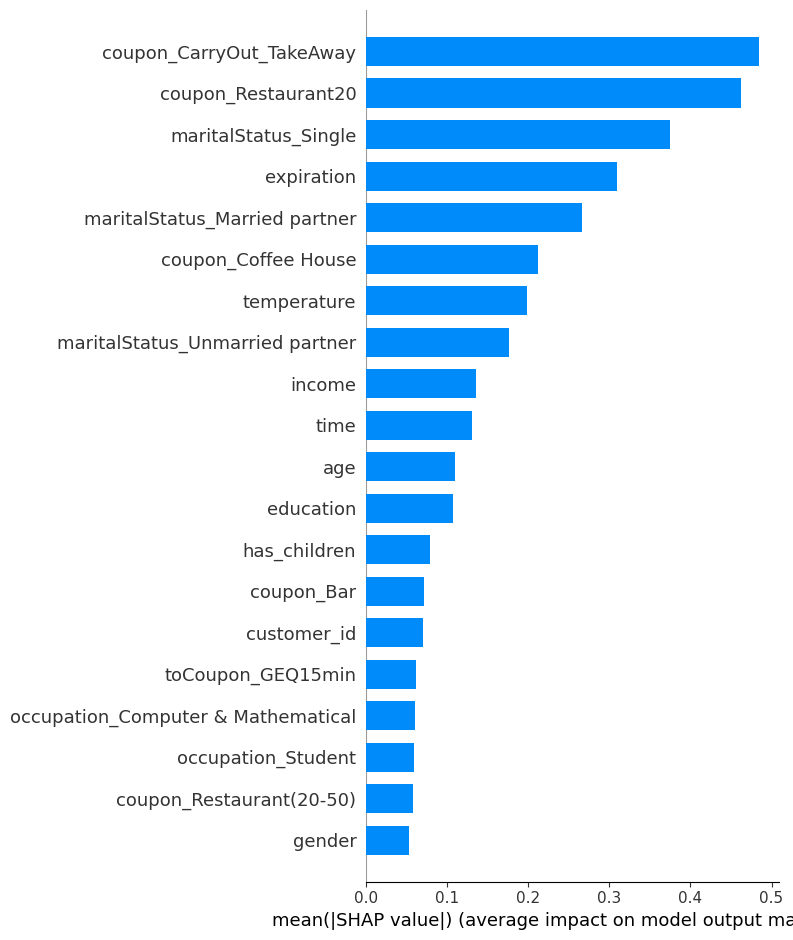

In [201]:
import shap

final_model = models['catboost'](logging_level = 'Silent',random_state =212)
final_model.fit(X_train_resample,y_train_resample)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train_resample)
shap.summary_plot(shap_values, X_train_resample, plot_type='bar')

In [212]:

y_pred= final_model.predict(test1)


In [214]:
y_pred.shape

(2537,)

In [210]:
y_pred_pd = pd.DataFrame(y_pred)

In [215]:
header = ['customer_id','Y']
y_pred_pd.to_csv("submission_pythonbytes1.csv")

In [216]:
final_model2 = models['randomForest']

In [223]:
from sklearn.model_selection import RandomizedSearchCV
import random
param_dist = {'n_estimators': random.randint(50,500),
              'max_depth': random.randint(1,20)}
RN = RandomizedSearchCV(final_model2, min_samples_split=3,
                           param_distributions = param_dist,
                           n_iter=5,
                           cv=5)

TypeError: ignored

In [226]:
from sklearn.model_selection import RandomizedSearchCV
rand_search = RandomizedSearchCV(final_model2,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)


In [229]:
rs = rand_search.fit(X_train_resample,y_train_resample)

TypeError: ignored